<a href="https://colab.research.google.com/github/prabindebnath25/NYC-Taxi-Trip-Time-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [72]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time


from geopy import distance

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge,ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Importing the dataset

In [2]:
# Mount the drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
# load the data
path = "/content/drive/MyDrive/regression capstone project/NYC Taxi Data.csv"
df = pd.read_csv(path)

In [85]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# EDA


In [86]:
# Check shape of the data
df.shape

(1458644, 11)

In [87]:
# Get some statiscis.
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [88]:
# Reveal information about the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [89]:
# Check if it contains null values.
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There is no null values in the data

In [90]:
# Change format for pickup_datetime to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [91]:
# Retrive day, month and hour data and drop 'pickup_datetime', 'dropoff_datetime' columns
df['weekday'] = df['pickup_datetime'].dt.weekday
df['month'] = df['pickup_datetime'].dt.month
df['hour'] = df['pickup_datetime'].dt.hour
df.drop(columns=['pickup_datetime', 'dropoff_datetime'], inplace= True)

In [92]:
df.store_and_fwd_flag.value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [93]:
df.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'weekday', 'month', 'hour'],
      dtype='object')

## Vendor ID

In [94]:
# Value counts for vendot id
df.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

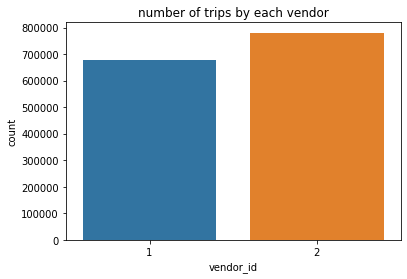

In [95]:
# plot number of trios by each vendors
sns.countplot(df['vendor_id'])
plt.title("number of trips by each vendor")
plt.show()

Text(0.5, 1.0, 'trip duration by each vendor')

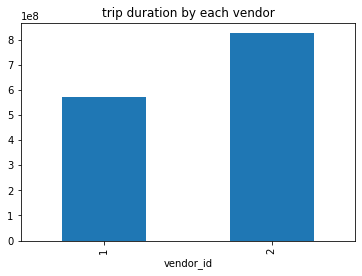

In [96]:
# Trip time comparison for each vendor
df.groupby(['vendor_id'])['trip_duration'].sum().plot(kind = 'bar')
plt.title('trip duration by each vendor')

* trip count of bendor 2 is more then vendor 1
* also total trip duration in vendor 2 is more thn vendor 1

## Passenger counts


In [97]:
# Value counts on passenger_count
df['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

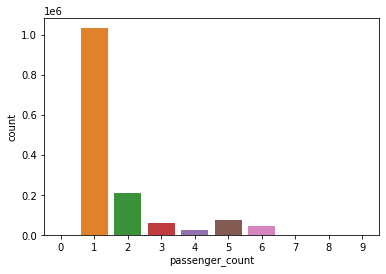

In [98]:
# Count plot on passenger_counts
sns.countplot(df['passenger_count'])
plt.show()

* ***some values are zero which mean either the trip was cancled or there was an error in the data entry.***
* ***7, 8, 9 are extreme cases considering the capacity of a car, so we will get rid of them.***
* ***most of the trips contain atmost 1 or 2 passengers.***

In [99]:
# removing rows with unwanted passenger counts
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <=6)]

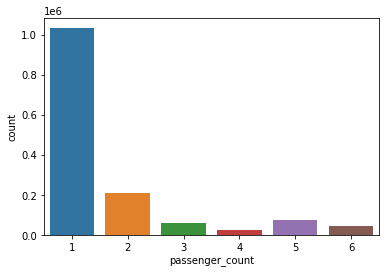

In [100]:
# after removing un wanted passenger counts
sns.countplot(df['passenger_count'])
plt.show()

## distance

In [101]:
# Create a function to calculate distances between pickup and drop off
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    dropoff =  (df['dropoff_latitude'], df['dropoff_longitude'])
    distance1 = distance.distance(pickup, dropoff).km
    return distance1

# Calculate distance 
df['distance'] = df.apply(lambda x: calc_distance(x), axis = 1)


In [102]:
df.distance.sort_values(ascending= True)

332415        0.000000
310909        0.000000
367162        0.000000
211652        0.000000
996539        0.000000
              ...     
923793      563.028024
1100676     575.600259
910072      578.579744
974378      891.663777
184925     1240.510256
Name: distance, Length: 1458579, dtype: float64

There are distances with 0 km we get ride of them

In [103]:
# Get rid of zero distance 
df = df[df['distance'] > 0]

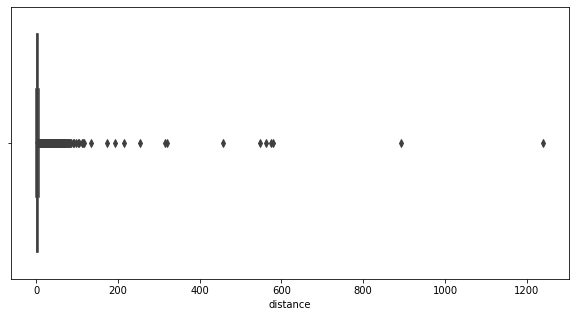

In [104]:
plt.figure(figsize= (10,5))
sns.boxplot(df['distance'])

In [105]:
# Number of trips with more then 100 km distance
df[df['distance'] > 100].shape[0]

19

there are only 19 rows with distance more then 100km we get rid of them

In [106]:
# get rid of rows with distance more then 100 km
df=  df[df['distance'] < 100]

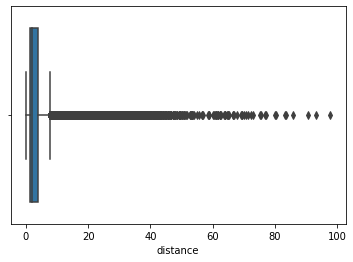

In [107]:
# boxplot after cleaning outliers
sns.boxplot(df['distance'])

## trip duration

In [108]:
# Trip duration in minutes
df['trip_duration_minute'] = df['trip_duration']/60

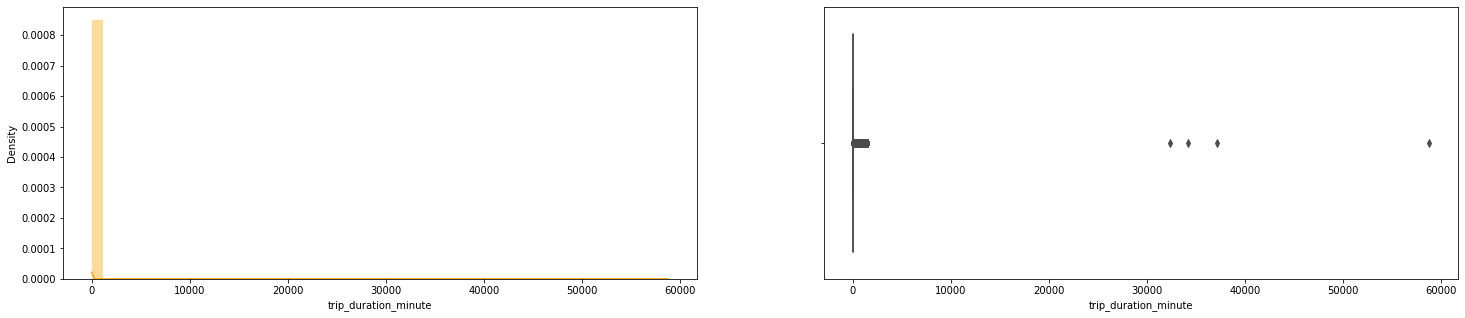

In [109]:
# Check out the trip_duration.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,5))
# plt.figure(figsize=(10,5))
sns.distplot(df['trip_duration_minute'], color='orange', ax=ax1)
sns.boxplot(df['trip_duration_minute'], color='orange', ax=ax2)
plt.show()

we drop the rows with outliers with more then 10000 minutes and also remove the trips with zero minutes time

In [110]:
# drop the rows with outliers with more then 10000 minutes and also remove the trips with zero minutes time
df = df[(df['trip_duration_minute'] < 1000) & (df['trip_duration_minute'] > 0) ]

In [111]:
# we take log to deal with skew ness
df['trip_duration_minute'] = np.log10(df['trip_duration_minute'])

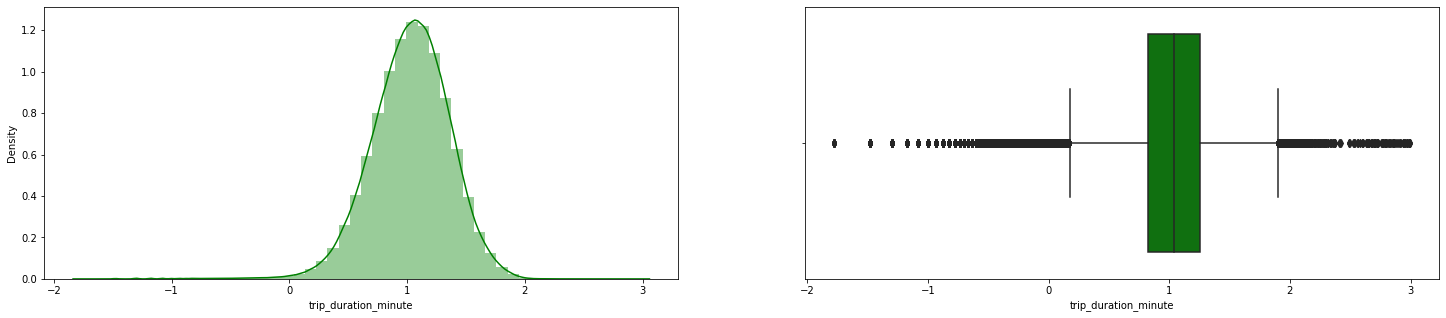

In [112]:
# Check out the trip_duration after removing outlieers and taking log.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,5))
# plt.figure(figsize=(10,5))
sns.distplot(df['trip_duration_minute'], color='green', ax=ax1)
sns.boxplot(df['trip_duration_minute'], color='green', ax=ax2)
plt.show()

# Data preparation

In [113]:
df.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'weekday', 'month', 'hour',
       'distance', 'trip_duration_minute'],
      dtype='object')

In [114]:
# drop some colums
df.drop(columns = ['id', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', ], inplace = True)

In [115]:
df.columns

Index(['vendor_id', 'passenger_count', 'weekday', 'month', 'hour', 'distance',
       'trip_duration_minute'],
      dtype='object')

In [117]:
# Since there are total 24 different values in these two columns it would be better to categorize them and get dummies for them.

# Function to convert pickup/dropoff hours to category.

def hour_category(hour):
    if hour>=7 and hour<=9:
        return 'rush_hour_morning(7-9)'
    elif hour>9 and hour<16:
        return 'normal_hour_afternoon(9-16)'
    elif hour>=16 and hour<=19:
        return 'rush_hour_evening(16-19)'
    elif hour>19 and hour<=23:
        return 'normal_hour_evining(19-23)'
    else:
        return 'latenight(23 onwards)'


In [118]:
#  apply hour category to hour column
df['pickup_time'] = df['hour'].apply(lambda x: hour_category(x))

# drop hour colun
df.drop(columns= ['hour'], inplace= True)

In [119]:
df.columns

Index(['vendor_id', 'passenger_count', 'weekday', 'month', 'distance',
       'trip_duration_minute', 'pickup_time'],
      dtype='object')

In [120]:
# One hot encoding
df = pd.get_dummies(df, columns= ['vendor_id', 'passenger_count', 'weekday', 'month', 'pickup_time'], drop_first= True)

In [122]:
df.columns

Index(['distance', 'trip_duration_minute', 'vendor_id_2', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'pickup_time_normal_hour_afternoon(9-16)',
       'pickup_time_normal_hour_evining(19-23)',
       'pickup_time_rush_hour_evening(16-19)',
       'pickup_time_rush_hour_morning(7-9)'],
      dtype='object')

In [123]:
df.shape

(1450716, 23)

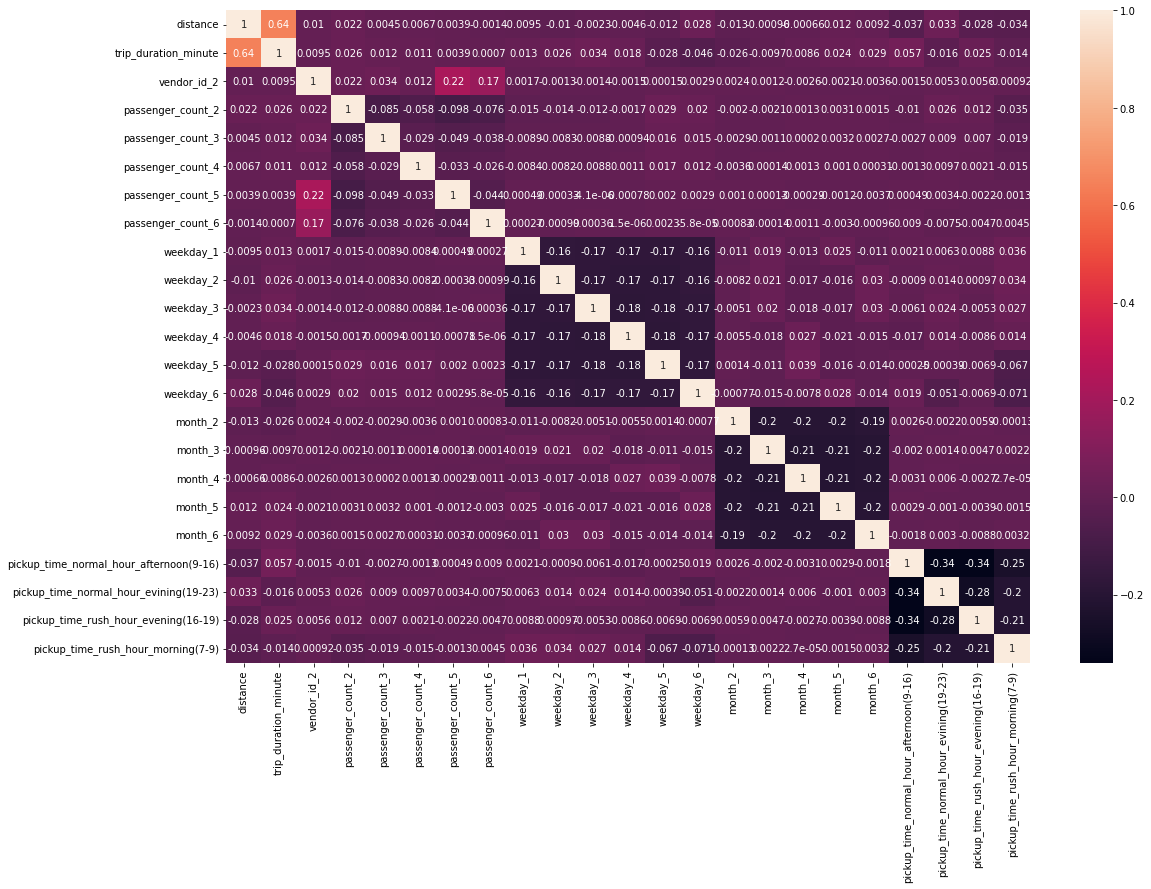

In [124]:
# plotting hit map
fig = plt.figure(figsize=(18,12))
colinearity = df.corr()
sns.heatmap(colinearity,annot= True)

In [126]:
dependent_variables = ['trip_duration_minute']
independent_variables = [i for i in df.columns if i not in dependent_variables]

In [127]:
# get x and y values
X = df[independent_variables]
y = np.log10(df[dependent_variables])
# Train Test Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state =5)

In [128]:
# Scale the data 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model selection


**Models we will be building:**
* **Linear Regression**
* **Decision Tree Regressorr**
* **XG Boost Regressor**
* **Hist Gradient Boosting Regressor**
* **AdaBoostRegressor**


In [47]:
# Defining the models to be used.
models = [['Linear Regression', LinearRegression()],
          ["Lasso", Lasso()],
          ["Ridge", Ridge()],
          ['Elastic net',ElasticNet() ],
          ['Decision Tree Regressor', DecisionTreeRegressor()],
          ['XG Boost Regressor', xgb.XGBRegressor()],
          ['Hist Gradient Boosting Regressor', HistGradientBoostingRegressor()],
          ['AdaBoostRegressor', AdaBoostRegressor()],
          ]

In [76]:
# creating a loop to train all the models and get eveluation metrics
model_eveluation_metrices =[]
for name, model in models:
    working_model ={}
    working_model['name'] = name
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    working_model['train_time'] = end - start
    working_model["Train_R2_Score"] = r2_score(10**(y_train),10**(model.predict(X_train)))
    working_model["Test_R2_Score"] = r2_score(10**y_test,10**(model.predict(X_test)))
    working_model["Test_RMSE_Score"] = np.sqrt(mean_squared_error(10**y_test,10**(model.predict(X_test))))
    model_eveluation_metrices.append(working_model)


model_eveluation_metrices_df = pd.DataFrame(model_eveluation_metrices)
model_eveluation_metrices_df



,name,train_time,Train_R2_Score,Test_R2_Score,Test_RMSE_Score
0,Hist Gradient Boosting Regressor,15.089066,0.563431,0.551821,8.310853


Looking at the above Performance Matrix we can say thay XGBoost and Hist Gradient Boosting Regressor are the best model for this dataset. however Hist Gradient Boosting Regressor model takes significantly less time so we decided to tune Hist Gradient Boosting Regressor model.

# Hyperparameter Tuning:

We will tune the parameters of Hist Gradient Boosting Regressor for better results.

In [60]:
# creating parameters
max_depth = [9,10]
learning_rate = [.2,0.3,0.4]
min_samples_leaf = [60,70]
max_iter = [400,500]

# param_dict
param_dict = {
    'learning_rate' : learning_rate, 
    'max_depth' : max_depth, 
    'min_samples_leaf' : min_samples_leaf ,
    'max_iter' : max_iter
}

# define the model 
hgbt = HistGradientBoostingRegressor()
#Grid Serch
hgbt_grid = GridSearchCV(estimator= hgbt, param_grid= param_dict, cv = 3, verbose = 2, scoring= 'r2')

# Train model
start = time.time()
hgbt_grid.fit(X_train, y_train)
end = time.time()
print("\n=========================================================\n")
print("Time required top train  ",end - start)

# Get the parameters
print("\n=========================================================\n")
print("Best parameters are  \n",hgbt_grid.best_params_)

# predit 
y_train_preds = hgbt_grid.best_estimator_.predict(X_train)
y_test_preds = hgbt_grid.best_estimator_.predict(X_test)

print("\n=========================================================\n")
Train_R2_Score = r2_score(y_train,y_train_preds)
Train_RMSE_Score = np.sqrt(mean_squared_error(y_train,y_train_preds))

Test_R2_Score = r2_score(y_test, y_test_preds)
Test_RMSE_Score = np.sqrt(mean_squared_error(y_test, y_test_preds))
print(f"Train_R2_Score  {Train_R2_Score}")
print(f"Test_R2_Score  {Test_R2_Score}")
print(f"Train_RMSE_Score   {Train_RMSE_Score}")
print(f"Test_RMSE_Score   {Test_RMSE_Score}")
print("\n=========================================================\n")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END learning_rate=0.2, max_depth=9, max_iter=400, min_samples_leaf=60; total time=  10.2s
[CV] END learning_rate=0.2, max_depth=9, max_iter=400, min_samples_leaf=60; total time=   7.6s
[CV] END learning_rate=0.2, max_depth=9, max_iter=400, min_samples_leaf=60; total time=  10.6s
[CV] END learning_rate=0.2, max_depth=9, max_iter=400, min_samples_leaf=70; total time=   9.2s
[CV] END learning_rate=0.2, max_depth=9, max_iter=400, min_samples_leaf=70; total time=  10.5s
[CV] END learning_rate=0.2, max_depth=9, max_iter=400, min_samples_leaf=70; total time=  11.3s
[CV] END learning_rate=0.2, max_depth=9, max_iter=500, min_samples_leaf=60; total time=   9.0s
[CV] END learning_rate=0.2, max_depth=9, max_iter=500, min_samples_leaf=60; total time=   7.9s
[CV] END learning_rate=0.2, max_depth=9, max_iter=500, min_samples_leaf=60; total time=   8.9s
[CV] END learning_rate=0.2, max_depth=9, max_iter=500, min_samples_leaf=70; total ti

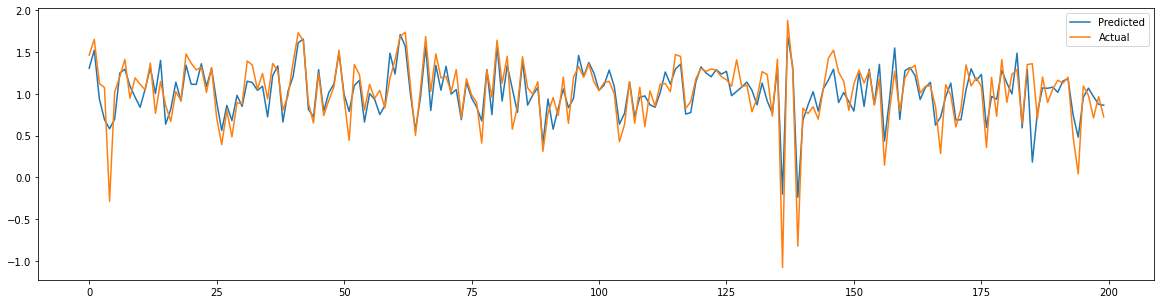

In [63]:
plt.figure(figsize=(20,5))
plt.plot(np.array(y_test_preds)[:200])
plt.plot(np.array(y_test)[:200])
plt.legend(["Predicted","Actual"])
plt.show()

# Conclusion
In this project ,covered various aspects of the Machine learning development cycle amd observed that the data exploration and variable analysis is a very important for the cycle and should be done for thorough understanding of the data. Also cleaned the data while exploring as there were some outliers which should be treated before feature engineering. Further performed feature engineering to filter and gather only the optimal features which are more significant.